# Logistic Regression

In this notebook, we'll see how to build and evaluate logistic regression models using the _statsmodels_ library.

We'll be working with a data set consisting of a sample of 200 subjects who were part of a study on survival of patients following admission to an adult intensive care unit. The goal of the study was to develop a logistic regression model to predict the probability of survival to hospital discharge of these patients.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
icu = pd.read_csv('../data/icu.csv')
icu.head()

,ID,STA,AGE,SEX,RACE,SER,CAN,CRN,INF,CPR,...,HRA,PRE,TYP,FRA,PO2,PH,PCO,BIC,CRE,LOC
0,552,0,16,0,1,1,0,0,0,0,...,140,0,1,1,0,0,0,0,0,0
1,102,0,16,1,1,0,0,0,0,0,...,111,0,1,0,0,0,0,0,0,0
2,837,0,17,1,3,0,0,0,0,0,...,140,0,1,0,0,0,0,0,0,0
3,863,0,17,0,3,1,0,0,0,0,...,78,0,1,0,0,0,0,0,0,0
4,829,0,17,0,1,1,0,0,0,0,...,78,0,1,1,0,0,0,0,0,0


The variables are as follows:

|Variable | Description | Codes/Values|
|---|---|---|
| ID | Identification Code | ID Number|
| STA | Vital Status | 0 = Lived<br /> 1 = Died |
| AGE | Age | Years |
| SEX | Sex | 0 = Male<br /> 1 = Female | 
| RACE | Race | 1 = White<br />2 = Black<br />3 = Other |
| SER | Service at ICU Admission | 0 = Medical<br />1 = Surgical |
| CAN | Cancer Part of Present Problem | 0 = No<br />1 = Yes |
| CRN | History of Chronic Renal Failure | 0 = No<br />1 = Yes |
| INF | Infection Probable at ICU Admission | 0 = No<br />1 = Yes |
| CPR | CPR Prior to ICU Admission | 0 = No<br />1 = Yes |
| SYS | Systolic Blood Pressure at ICU Admission | mm Hg |
| HRA | Heart Rate at ICU Admission | Beats/min |
| PRE | Previous Admission to an ICU Within 6 Months | 0 = No<br />1 = Yes |
| TYP | Type of Admission | 0 = Elective<br />1 = Emergency |
| FRA | Long Bone, Multiple, Neck, Single Area, or Hip Fracture | 0 = No<br />1 = Yes |
| PO2 | PO2 from Initial Blood Gases | 0: $>$60<br />1: $\leq$ 60 |
| PH | PH from Initial Blood Gases | 0: $\geq$ 7.25<br />1: $<$7.25 |
| PCO | PCO2 from Initial Blood Gases | 0: $\leq$ 45<br />1: $>$45 |
| BIC | Bicarbonate from Initial Blood Gases | 0: $\geq$ 18<br />1: $<$ 18 |
| CRE | Creatinine from Initial Blood Gases | 0: $\leq$2.0<br />1: $>$2.0 |
| LOC | Level of Consciousness at ICU Admission | 0 = No Coma or Deep Stupor<br />1 = Deep Stupor<br />2 = Coma |

### Exploratory Analysis

We can start by looking at the relationship between age and status. The main question of interest is how a patient's age impacts their chances of dying.

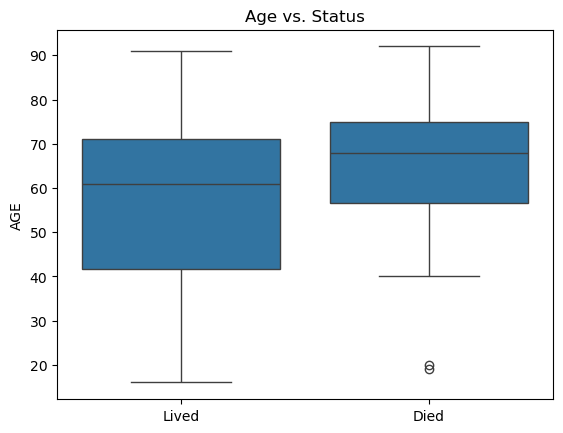

In [3]:
sns.boxplot(data = icu, y = 'AGE', x = 'STA')
plt.xticks([0,1], ['Lived', 'Died'])
plt.xlabel('')
plt.title('Age vs. Status');

Since our target is the patient's status and we are using age as a predictor, we could also look at the data using a different plot.

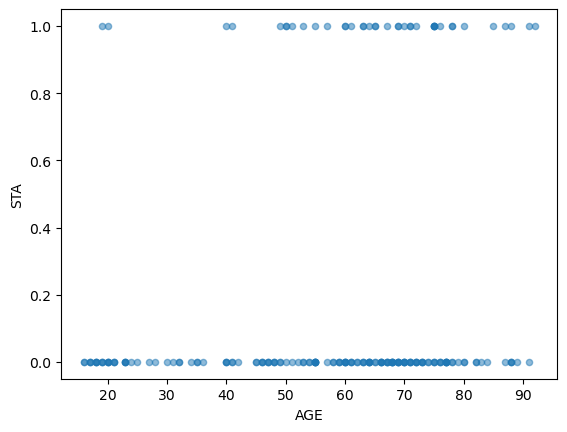

In [4]:
icu.plot(
    kind="scatter",
    x="AGE",
    y="STA",
    alpha=0.5
);

We could look at the distribution of ages by status.

In [5]:
icu.groupby('STA')['AGE'].describe()

,count,mean,std,min,25%,50%,75%,max
STA,,,,,,,,
0,160.0,55.650,20.428184,16.0,41.75,61.0,71.0,91.0
1,40.0,65.125,16.648997,19.0,56.50,68.0,75.0,92.0


In [6]:
(
    icu
    .assign(age_group = pd.cut(
        icu['AGE'], 
        bins = np.arange(start=0, stop=110, step=10)
    )
           )
    .groupby('age_group', observed=True)
    ['STA'].agg(['mean', 'count'])
)

,mean,count
age_group,,
"(10, 20]",0.111111,18
"(20, 30]",0.000000,12
"(30, 40]",0.090909,11
"(40, 50]",0.190476,21
"(50, 60]",0.200000,30
"(60, 70]",0.200000,50
"(70, 80]",0.279070,43
"(80, 90]",0.250000,12
"(90, 100]",0.666667,3


What do we observe from all of the above calculations?

### Fitting the Model

In order to fit our model, we'll again be using the statsmodels's formula api.

In [7]:
import statsmodels.formula.api as sm

We can fit a logistic regression model similarly to how we fit a linear regression model, but this time using `logit`.

Again, we use a formula specifying `target ~ predictor(s)`.

In [8]:
logreg = sm.logit('STA ~ AGE', data = icu).fit()

Optimization terminated successfully.
         Current function value: 0.480766
         Iterations 6


The summary method shows coefficient estimates and confidence intervals.

In [9]:
logreg.params

Intercept   -3.058513
AGE          0.027543
dtype: float64

This says that 

P(STA=1) = logistic(-3.058513 + 0.027543*(AGE))

If we want to get these estimates, we need to build a way to compute the logistic function.

In [10]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

We can now call this function like any other function.

In [11]:
logistic(0)

np.float64(0.5)

We can try it out to see what the model estimates the probability of dying is for different ages.

In [12]:
age = 90
logistic(logreg.params['Intercept'] + age*logreg.params['AGE'])

np.float64(0.35900659905699006)

**Important Note:** Unlike linear regression, there is a not an easy interpretation of the coefficents because of the logistic function. The change in estimated probability for a one-unit change depends on the initial value.

For example, let's see the change in predicted probability between age 30 and age 31.

In [13]:
age_1 = 30
age_2 = 31

logistic(logreg.params['Intercept'] + age_2*logreg.params['AGE']) - logistic(logreg.params['Intercept'] + age_1*logreg.params['AGE'])

np.float64(0.0024370098750352287)

And compare this to the change from age 80 to 81.

In [14]:
age_1 = 80
age_2 = 81

logistic(logreg.params['Intercept'] + age_2*logreg.params['AGE']) - logistic(logreg.params['Intercept'] + age_1*logreg.params['AGE'])

np.float64(0.005797672690794564)

We can get predicted probabilities using the `predict` method and passing in a DataFrame with the expected variables.

In [15]:
logreg.predict(icu)

0      0.068000
1      0.068000
2      0.069766
3      0.069766
4      0.069766
         ...   
195    0.346431
196    0.352693
197    0.365369
198    0.365369
199    0.371779
Length: 200, dtype: float64

### Logistic Regression Inference

* How precise is our estimate of the coefficient associated with age?
* Is the coefficient associated with age statistically significant?
* If I add additional predictor variables, are their coefficients statistically significant, after controlling for age?

For the first question, we could look at a confidence interval for the coefficient.

In [16]:
logreg.conf_int()

,0,1
Intercept,-4.422887,-1.694139
AGE,0.006836,0.048249


We can see that there is a pretty wide confidence interval.

Let's check the next question, whether the coefficient is statistically significant.

In [17]:
logreg.pvalues['AGE']

np.float64(0.009132639447907511)

Yes, with such a small p-value, we can conclude that the effect is statistically significant.

Finally, let's look at the last question, if I add additional predictor variables, are their coefficients statistically significant, after controlling for age? Specifically, let's look at the sex variable.

**Question:** Is the coefficient for SEX statistically significant, after controlling for AGE?

**Null Hypothesis:** $\beta_{sex} = 0$

**Alternative Hypothesis:** $\beta_{sex} \neq 0$

In [18]:
logreg_age = sm.logit('STA ~ AGE + SEX', data = icu).fit()

Optimization terminated successfully.
         Current function value: 0.480764
         Iterations 6


Then we can check the p-values.

In [19]:
logreg_age.pvalues['SEX']

np.float64(0.9757284946650978)

**Conclusion:** Do not reject the null hypothesis. There is not enough evidence to conclude that the effect of sex is statistically significant, after controlling for age.

### Generating Predictions

In [20]:
from sklearn.model_selection import train_test_split

If we want to evaluate how well our model does at making predictions, we need to first divide it into a training set and a test set. The purpose of this is to allow us to see how well the model predicts on new, unseen data. We'll use a portion of our data to estimate the coefficients and then the rest to see how well it makes predictsions.

For this, we'll use the `train_test_split` function from scikit-learn. We need to give the full dataset, the proportion that we want to split off as a test set, and we can also specify if we want to stratify our split.

Stratifying will ensure that the proportion of the stratify variable is the same in the training data and in the test data.

In [21]:
icu_train, icu_test = train_test_split(icu, test_size = 0.25, stratify = icu['STA'], random_state = 321)

Let's fit a model that uses all of the variables.

In [22]:
logreg_pred = sm.logit('STA ~ AGE + SYS + SER + TYP + PO2 + PH + PCO + BIC + CRE + C(LOC)',
                       data = icu_train).fit()

         Current function value: 0.325574
         Iterations: 35


C:\Users\shann\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Once we have fit our model, we can generate predictions on the test data using the `predict` method.

In [23]:
logreg_pred.predict(icu_test)

170    0.158115
198    0.448367
32     0.061844
192    0.104327
0      0.045050
3      0.023248
16     0.020987
14     0.055025
138    0.300349
132    0.165775
121    0.018453
45     0.140844
90     1.000000
161    0.645453
42     0.464365
28     0.005653
199    0.434908
191    0.507142
129    0.970971
1      0.062747
10     0.005372
136    0.516683
177    0.510825
18     0.046291
180    0.017413
29     0.053780
36     0.014586
158    0.016362
73     0.187352
72     0.017255
150    0.038604
178    0.329047
62     0.230401
108    0.032853
87     0.295098
47     0.401710
97     0.005602
37     0.226511
4      0.021475
186    0.050455
98     0.957138
40     0.061257
155    0.016933
83     0.346834
15     0.036454
135    0.136336
13     0.049739
118    0.480075
143    0.362474
33     0.081371
dtype: float64

Recall that we'll predict that a patient will die if this probability is greater than 0.5.

In [24]:
y_pred = logreg_pred.predict(icu_test) > 0.5
y_pred

170    False
198    False
32     False
192    False
0      False
3      False
16     False
14     False
138    False
132    False
121    False
45     False
90      True
161     True
42     False
28     False
199    False
191     True
129     True
1      False
10     False
136     True
177     True
18     False
180    False
29     False
36     False
158    False
73     False
72     False
150    False
178    False
62     False
108    False
87     False
47     False
97     False
37     False
4      False
186    False
98      True
40     False
155    False
83     False
15     False
135    False
13     False
118    False
143    False
33     False
dtype: bool

We can use the crosstab function if we want to see how well the predicted values matche up to the true labels. When doing this, we have created what is called a **confusion matrix**.

In [25]:
pd.crosstab(icu_test['STA'], y_pred)

col_0,False,True
STA,,
0,38,2
1,5,5


The correct predictions are on the main diagonal.

There are a few metrics we could use to evaluate this model. Scikit-learn has a lot of these already written, so we'll import them. Generally, you need to give the true labels and then then predicted labels.

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

**Accuracy** give the percentage of correct predictions.

In [27]:
accuracy_score(icu_test['STA'], y_pred)

0.86

Note that there are two ways that we could be wrong. We could predict that someone will die when they actually survive. This is a **false positive**. On the other hand, we could predict that a person will survive when they actually die. This is a **false negative**.

There are a number of measures that consider the type of error we have made. We'll look at **precision** and **recall**, but there are others. See [this wikipedia page](https://en.wikipedia.org/wiki/Precision_and_recall).

**Precision** measures the percentage of our positive predictions which were correct.

$$Precision = \frac{TP}{TP + FP}$$

In [28]:
precision_score(icu_test['STA'], y_pred)

0.7142857142857143

**Recall** measures the percentage of the positive cases that were correctly predicted.

$$Recall = \frac{TP}{TP + FN}$$

In [29]:
recall_score(icu_test['STA'], y_pred)

0.5